제목: 전설의 포켓몬 찾기 일반화 성능 높이기
==========================

## 개요
모델 규제 및 하이퍼파라미터 튜닝을 통해서 전설의 포켓몬 찾기 일반화 성능 높이고자 한다.

### 목차
1. Summary
2. 개선
    1) 유용하지 않을 것 같은 특성 제거 시도
    2) 모델의 변경 
3. 회고


Summary
----------
### 디시전 트리에서는 유용하지 않을 것 같은 특성 제거가 의미가 있었으나, 신경망 모델에서는 오히려 모델의 신뢰도가 급격히 상실되었음. 신경망 모델에서는 히든 레이어가 있는 것이 도움이 되었고, 층의 크기가 층분히 큰 것도 정확도 개선에 도움이 되었다. L2 규제나 드랍아웃은 유의미한 개선을 이루지는 못했다.

개선
----------

### 유용하지 않을 것 같은 특성 제거
1. 상관관계를 분석해본다
2. 인터넷으로 포켓몬 게임에서의 전설의 포켓몬 특징을 교차 검증해본다

#### 상관관계 분석

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [2]:
original_data = pd.read_csv('Pokemon.csv')

In [3]:
pokemon = original_data.copy()
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True


In [4]:
# 공백만 제거하고 이름 길이 추가
pokemon["Name"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))

In [5]:
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7
796,719,DiancieMegaDiancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,18
797,720,HoopaHoopaConfined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,18
798,720,HoopaHoopaUnbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,17
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9


In [6]:
# 상관관계 조사를 위해서 숫자 칼럼만 남김
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count']
pokemon_corr = pokemon[features]
pokemon_corr

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,318,45,49,49,65,65,45,1,False,9
1,405,60,62,63,80,80,60,1,False,7
2,525,80,82,83,100,100,80,1,False,8
3,625,80,100,123,122,120,80,1,False,20
4,309,39,52,43,60,50,65,1,False,10
...,...,...,...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50,6,True,7
796,700,50,160,110,160,110,110,6,True,18
797,600,80,110,60,150,130,70,6,True,18
798,680,80,160,60,170,130,80,6,True,17


In [7]:
data = pokemon_corr.corr()
data

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
Total,1.000000,0.618748,0.736211,0.612787,0.747250,0.717609,0.575943,0.048384,0.501758,0.480152
HP,0.618748,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683,0.273620,0.185767
Attack,0.736211,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451,0.345408,0.412561
Defense,0.612787,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419,0.246377,0.309320
Sp. Atk,0.747250,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437,0.448907,0.397248
Sp. Def,0.717609,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486,0.363937,0.310635
Speed,0.575943,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121,0.326715,0.281384
Generation,0.048384,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000,0.079794,0.074817
Legendary,0.501758,0.273620,0.345408,0.246377,0.448907,0.363937,0.326715,0.079794,1.000000,0.211952
name_count,0.480152,0.185767,0.412561,0.309320,0.397248,0.310635,0.281384,0.074817,0.211952,1.000000


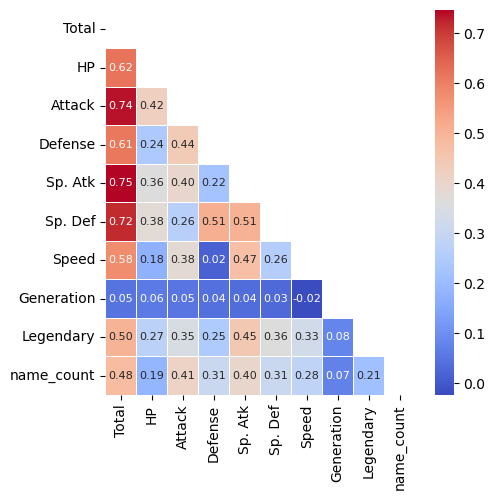

In [11]:
# seaborn 0.12 버전이 오류가 있어서 히트맵에 숫자가 안떴음. 0.13.2로 업그레이드 함
plt.figure(figsize=(5,5))
mask = np.zeros_like(data, dtype=bool) # 히트맵 절반만 표시하기 위함
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(data, mask=mask, annot=True, fmt = '.2f', cmap="coolwarm", annot_kws={"size": 8}, linewidths=0.5)
plt.show()


#### 사전조사

##### 인터넷으로 조사한 포켓몬 게임에서 전설의 포켓몬 특징(출처: ChatGPT)
1. 높은 기본 능력치
2. 고유한 기술
3. 시그니처 무브먼트
4. 희귀성
5. 게임의 메인스토리 연관성

##### 위 상관관계 분석에서 도출된 내용
1. 총 능력치와 높은 상관관계를 보임
2. Sp. Atk과 높은 상관관계를 보임

##### 적용
* 훈련 데이터를 더욱 압축해서 상관관계가 높은 2개만 가지고 훈련해본다

In [12]:
features_corr = ['Total', 'Sp. Atk']
target = 'Legendary'

In [13]:
X = original_data[features_corr]
print(X.shape)
X.head()

(800, 2)


,Total,Sp. Atk
0,318,65
1,405,80
2,525,100
3,625,122
4,309,60


In [14]:
y = original_data[target]
print(y.shape)
y.tail()

(800,)


795    True
796    True
797    True
798    True
799    True
Name: Legendary, dtype: bool

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 2) (640,)
(160, 2) (160,)


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

confu_matrix_ratio = confusion_matrix(y_test, y_pred)
print(confu_matrix_ratio)
print(f'디시전트리 모델 정확도: {(confu_matrix_ratio[0][0]+confu_matrix_ratio[1][1])/confu_matrix_ratio.sum()}')

[[143   4]
 [  2  11]]
디시전트리 모델 정확도: 0.9625


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       147
        True       0.73      0.85      0.79        13

    accuracy                           0.96       160
   macro avg       0.86      0.91      0.88       160
weighted avg       0.97      0.96      0.96       160



#### <유용하지 않을 것 같은 특성 제거 시도> 결과
1. 디시전트리 매트릭스 모델 정확도: 95.625% → 96.25%로 0.625%p 개선됨
2. recall 수치: 92% → 85%로 하락함
   - 이것은 FN 값이 이전 데이터 세트로 훈련했을 때 1이었는데, 2로 증가하면서 영향을 미친 것 같음

#### 결론
1. 전설의 포켓몬을 찾아야 하는 것이 목표이기 때문에 모델의 정확도는 개선되었으나, recall 수치가 하락하여 전설의 포켓몬을 찾는 확률이 오히려 떨어졌으므로 다른 개선 방법이 필요하다는 의견임

### 훈련 모델의 변경
1. 4장 집 값 모델을 적용해본다? 왜?
    - 주어진 데이터가 집 값의 예측 모델에서처럼 다양한 요소들로 이루어진 테이블임
    - 인터넷 조사와 상관관계 분석상 각각의 요소들이 완전히 무관하지는 않음
    - 결과 값만 binary하게 나오게 튜닝하면 될 듯

#### 훈련 모델의 변경 

##### 데이터준비 - 벡터화

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
pokemon = original_data.copy()

# 공백만 제거하고 이름 길이 추가
pokemon["Name"] = pokemon["Name"].apply(lambda i: i.replace(" ", "")) 
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))

In [10]:
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'name_count']
target = 'Legendary'

In [11]:
X = pokemon[features]
print(X.shape)
X.head()

(800, 9)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count
0,318,45,49,49,65,65,45,1,9
1,405,60,62,63,80,80,60,1,7
2,525,80,82,83,100,100,80,1,8
3,625,80,100,123,122,120,80,1,20
4,309,39,52,43,60,50,65,1,10


In [12]:
y = pokemon[target]
print(y.shape)
y.tail()

(800,)


795    True
796    True
797    True
798    True
799    True
Name: Legendary, dtype: bool

##### 평가 방법 선택 - 홀드아웃

In [13]:
# 데이터가 충분하지 않으므로 반복 K-겹 교차 검증을 추후에 시도할 예정임

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 9) (640,)
(160, 9) (160,)


In [14]:
y_train

300    False
351    False
193    False
794     True
798     True
       ...  
156     True
384    False
645    False
757    False
456    False
Name: Legendary, Length: 640, dtype: bool

In [15]:
X_train

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count
300,430,60,85,60,50,50,125,3,7
351,500,170,90,45,90,45,60,3,7
193,280,55,40,40,65,45,35,2,6
794,600,108,100,121,81,95,95,6,15
798,680,80,160,60,170,130,80,6,17
...,...,...,...,...,...,...,...,...,...
156,580,90,85,100,95,125,85,1,8
384,440,60,90,70,60,120,40,3,7
645,535,71,95,85,110,95,79,5,9
757,482,86,92,88,68,75,73,6,7


##### 데이터준비 - 정규화

In [16]:
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std
X_test -= mean
X_test /= std

##### 기준모델 - 통계적 검정력을 달성하는 모델 만들기

In [50]:
# 입력층과 출력층으로만 심플하게 구성

def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [52]:
model = build_model()
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3005 - loss: 0.8889 - val_accuracy: 0.3000 - val_loss: 0.7957
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3912 - loss: 0.7831 - val_accuracy: 0.4000 - val_loss: 0.7298
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4385 - loss: 0.7260 - val_accuracy: 0.5063 - val_loss: 0.6737
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5283 - loss: 0.7035 - val_accuracy: 0.7188 - val_loss: 0.6242
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6849 - loss: 0.6464 - val_accuracy: 0.8125 - val_loss: 0.5797
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7942 - loss: 0.6024 - val_accuracy: 0.8313 - val_loss: 0.5398
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 0.5550 - val_accuracy: 0.8500 - val_loss: 0.5031
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8658 - loss: 0.5140 - val_accuracy: 0.8750 - val_loss

##### 기준 모델: 통계적 검정력 달성 여부
- 오리지널 데이터에서 일반 포켓몬 맞출 수 있는 확률: 0.91875
- 검증 정확도: 0.9438
- 결론: 아주 간단한 기준점은 넘은 것 같음

In [53]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

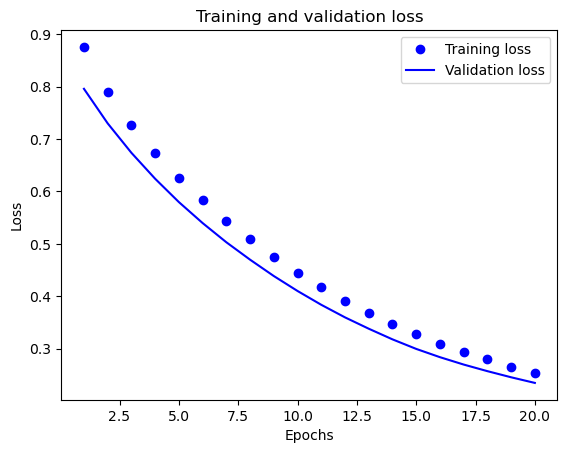

In [54]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

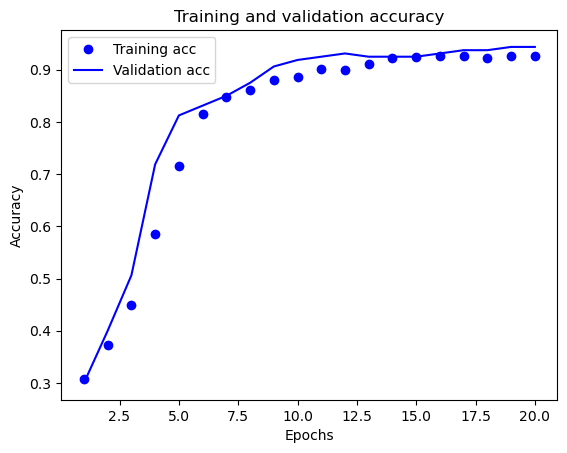

In [55]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### 과대적합 모델 만들기
1. 층 추가
2. 층 크기 키우기
3. 더 많은 에포크 훈련

In [78]:
def build_model_overfit():
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [79]:
model = build_model_overfit()
history = model.fit(X_train, y_train,
                    epochs=200, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8723 - loss: 0.4406 - val_accuracy: 0.9187 - val_loss: 0.2500
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9222 - loss: 0.2260 - val_accuracy: 0.9187 - val_loss: 0.1892
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9441 - loss: 0.1643 - val_accuracy: 0.9312 - val_loss: 0.1549
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - loss: 0.1550 - val_accuracy: 0.9312 - val_loss: 0.1387
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9533 - loss: 0.1158 - val_accuracy: 0.9375 - val_loss: 0.1318
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9659 - loss: 0.1004 - val_accuracy: 0.9375 - val_loss: 0.1209
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.0972 - val_accuracy: 0.9438 - val_loss: 0.1144
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9735 - loss: 0.0784 - val_accuracy: 0.9500 - 

In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

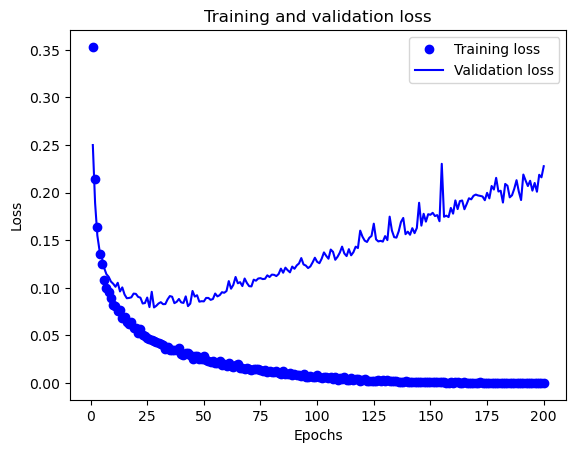

In [81]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

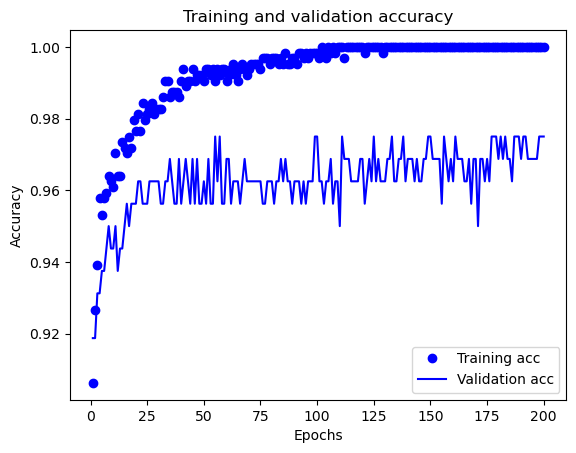

In [82]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### 26 에포크부터는 검증손실이 떨어지지 않고 다시 오르는 상황
- 과대적합 모델이 잘 만들어진 것 같음
- 정확도는 26 에포크에서 0.9625로 오리지널 데이터에서 일반 포켓몬 맞출 수 있는 확률(0.91875)이나, 기준 모델 검증 정확도(0.9438) 보다는 향상되었으나, 디시전트리 검증 정확도(0.9625)보다는 더 개선되지는 않았음

##### 일반화 성능 최대화 시도
- 에포크 줄이기
- 하이퍼파라미터 변경: 층 크기 변경하기
- L2 규제 적용
- 드랍아웃 적용
- 유용하지 않을 것 같은 특성 제거까지 결합해보기


In [17]:
# 에포크 줄이고, 층 크기 더 크게 하기
def build_model_fit():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(512, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [18]:
model = build_model_fit()
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8388 - loss: 0.3999 - val_accuracy: 0.9250 - val_loss: 0.1785
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9442 - loss: 0.1542 - val_accuracy: 0.9187 - val_loss: 0.1551
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 0.1515 - val_accuracy: 0.9375 - val_loss: 0.1285
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9697 - loss: 0.1019 - val_accuracy: 0.9438 - val_loss: 0.1205
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9498 - loss: 0.0984 - val_accuracy: 0.9438 - val_loss: 0.1075
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9638 - loss: 0.0851 - val_accuracy: 0.9438 - val_loss: 0.0972
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9721 - loss: 0.0675 - val_accuracy: 0.9438 - val_loss: 0.1000
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0718 - val_accuracy: 0.9563 - val_loss

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

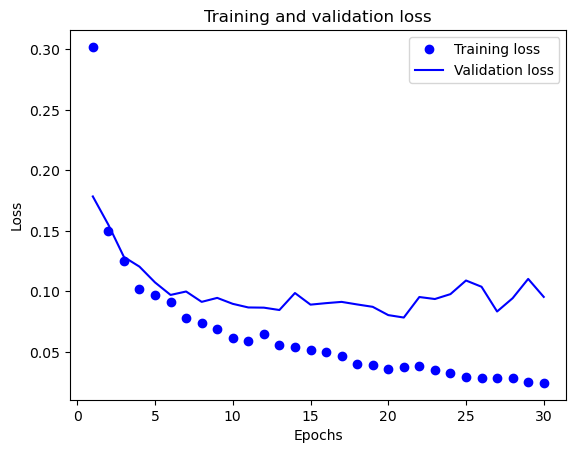

In [20]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

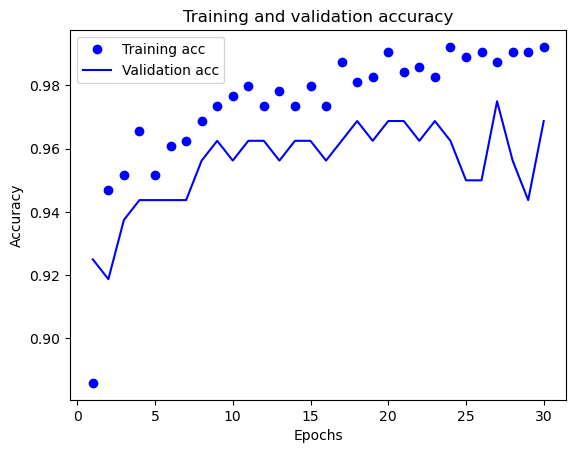

In [21]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### 층 크기를 더 키우기 적용 결론
- 정확도는 27 에포크에서 0.9750로 오리지널 데이터에서 일반 포켓몬 맞출 수 있는 확률(0.91875)이나, 기준 모델 검증 정확도(0.9438) 보다는 향상되었으나, 디시전트리 검증 정확도(0.9625)보다도 더 개선됨
- 다만, 검증 손실이 불안정 하므로 다음에는 L2 규제를 도입해보겠음

In [22]:
# L2 규제 도입
from tensorflow.keras import regularizers

def build_model_l2():
    model = keras.Sequential([
        layers.Dense(512, 
                        kernel_regularizer=regularizers.l2(0.002),
                        activation="relu"),
        layers.Dense(512, 
                        kernel_regularizer=regularizers.l2(0.002),
                        activation="relu"),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [23]:
model = build_model_l2()
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7586 - loss: 1.4125 - val_accuracy: 0.9312 - val_loss: 1.0476
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9461 - loss: 0.9826 - val_accuracy: 0.9312 - val_loss: 0.8380
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9582 - loss: 0.7753 - val_accuracy: 0.9563 - val_loss: 0.6723
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9555 - loss: 0.6517 - val_accuracy: 0.9375 - val_loss: 0.5628
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9697 - loss: 0.5118 - val_accuracy: 0.9438 - val_loss: 0.4681
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9590 - loss: 0.4236 - val_accuracy: 0.9500 - val_loss: 0.3863
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9655 - loss: 0.3532 - val_accuracy: 0.9375 - val_loss: 0.3395
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9679 - loss: 0.2978 - val_accuracy: 0.9438 - val_loss

In [24]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

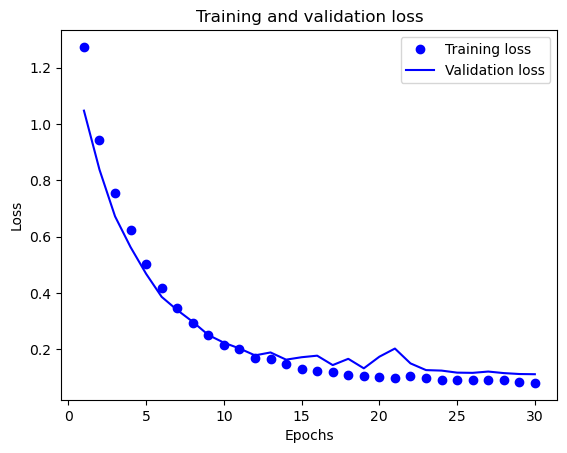

In [25]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

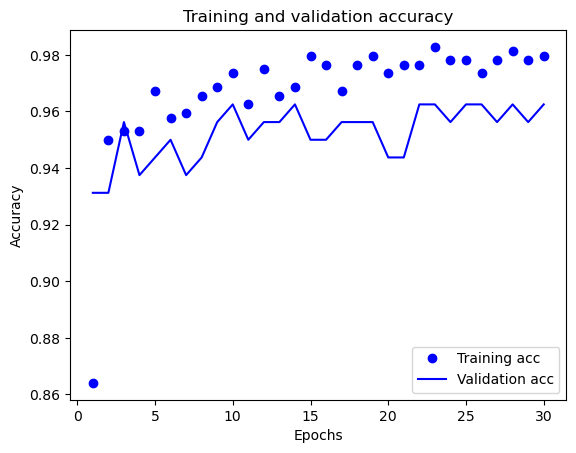

In [26]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### L2 규제 적용 결론
- 정확도는 0.9625에서 더 올라가지 못하고 있음



In [27]:
# 드랍아웃 적용

def build_model_drop():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [32]:
model = build_model_drop()
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8405 - loss: 0.3732 - val_accuracy: 0.9187 - val_loss: 0.1892
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9165 - loss: 0.1888 - val_accuracy: 0.9250 - val_loss: 0.1570
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9455 - loss: 0.1394 - val_accuracy: 0.9187 - val_loss: 0.1513
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9518 - loss: 0.1208 - val_accuracy: 0.9375 - val_loss: 0.1294
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9537 - loss: 0.1271 - val_accuracy: 0.9250 - val_loss: 0.1381
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9584 - loss: 0.1157 - val_accuracy: 0.9250 - val_loss: 0.1502
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9512 - loss: 0.1039 - val_accuracy: 0.9312 - val_loss: 0.1287
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9520 - loss: 0.1017 - val_accuracy: 0.9375 - 

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

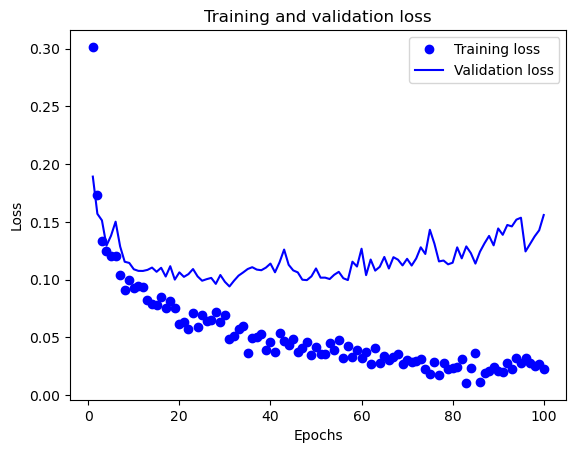

In [34]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

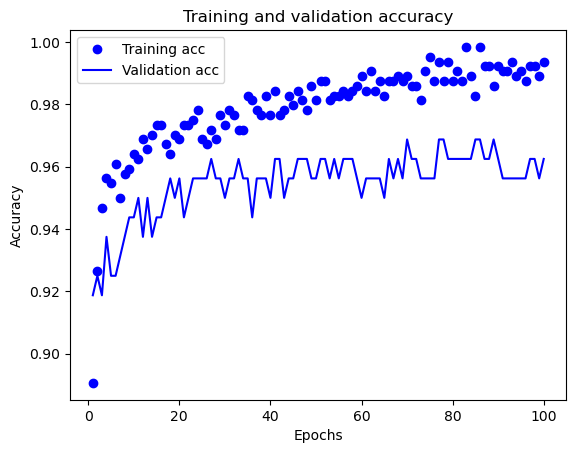

In [35]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### 드랍아웃 적용 결론
- 정확도는 0.9688까지 나오나, 검증 손실이 늘어나고 있어서 의미 있는 것인지는 모르겠음


In [36]:
# 유용하지 않을 것 같은 특성 제거

features_corr = ['Total', 'Sp. Atk']
target = 'Legendary'

In [57]:
X = original_data[features_corr]
print(X.shape)
X.head()

(800, 2)


,Total,Sp. Atk
0,318,65
1,405,80
2,525,100
3,625,122
4,309,60


In [58]:
y = original_data[target]
print(y.shape)
y.tail()

(800,)


795    True
796    True
797    True
798    True
799    True
Name: Legendary, dtype: bool

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 2) (640,)
(160, 2) (160,)


In [60]:
# 층 크기를 줄어든 데이터 양에 비례해서 줄임
def build_model_useful():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # 이진 값으로 변경
    ])
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"]) # 손실함수는 이진함수로 넣고, 평가지표는 정확도로 함
    return model

In [61]:
model = build_model_useful()
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=50, 
                    validation_data=(X_test, y_test))

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6901 - loss: 3.6179 - val_accuracy: 0.9187 - val_loss: 1.0480
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7747 - loss: 1.3766 - val_accuracy: 0.9187 - val_loss: 2.5079
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9080 - loss: 1.4635 - val_accuracy: 0.9187 - val_loss: 0.9915
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8327 - loss: 1.2928 - val_accuracy: 0.9187 - val_loss: 1.1468
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9033 - loss: 0.7497 - val_accuracy: 0.9125 - val_loss: 0.4640
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8487 - loss: 0.7015 - val_accuracy: 0.9125 - val_loss: 0.3924
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8268 - loss: 1.1375 - val_accuracy: 0.8375 - val_loss: 0.4623
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8402 - loss: 0.6519 - val_accuracy: 0.7812 - 

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

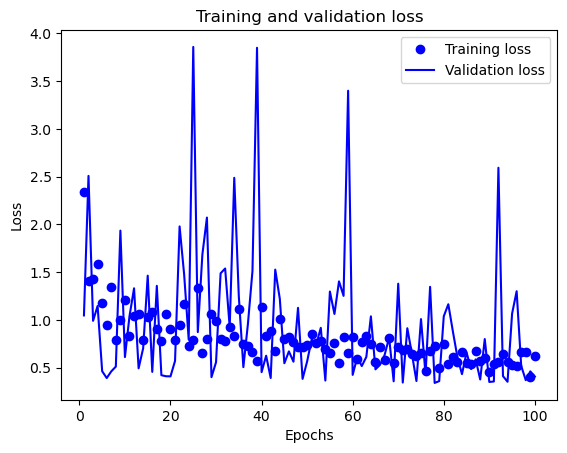

In [63]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

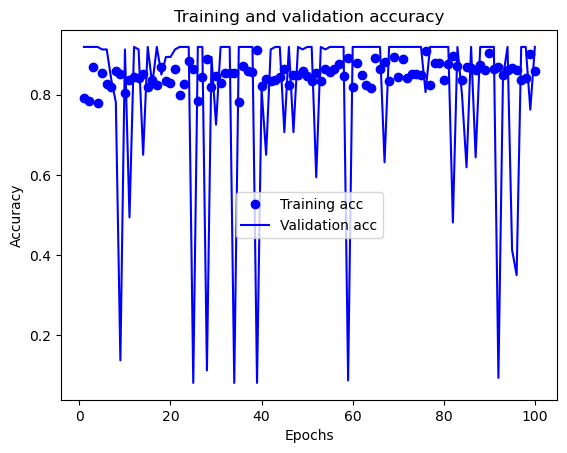

In [64]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##### 유용하지 않을 것 같은 특성 제거 결론
- 정확도는 0.91~0.93대에서 개선되지 않음. 너무 적은 데이터로 학습 시키면 오히려 모델의 신뢰도가 급격하게 상실되는 것 같음

회고
-----
1. 일반화 성능을 높이는 과정은 상당히 힘들고 반복적인 작업들의 수행을 요구했음
2. 향후에 반복 K-겹 검증을 결합해보고 싶음